In [1]:
import torch
import  torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [2]:
from pathlib import Path
import os
root=Path(os.getcwd())
train_path=root / 'tiny-imagenet-200' / 'tiny-imagenet-200' / 'train'

In [3]:
len(os.listdir(train_path))

200

## Transform

In [4]:
transform=transforms.Compose([
    transforms.Resize((224,224)),  #Para pasar a 224 x 224 pixels
    transforms.ToTensor()          #Para convertir la imagen a tensor
])

## Path of dataset

In [5]:
from pathlib import Path

root_data_path=Path('tiny-imagenet-200')

root_data_path

WindowsPath('tiny-imagenet-200')

In [6]:
import os

def walk_through_dir(dir_path):
    for dirpath,dir_names,file_names in os.walk(dir_path):
        print(f"There are {len(dir_names)} directories and {len(file_names)} images in {dirpath}")

In [7]:
tiny_imagenet_200_path=root_data_path / 'tiny-imagenet-200'

train_tiny_imagenet_200_path= tiny_imagenet_200_path / 'train'

train_tiny_imagenet_200_path

WindowsPath('tiny-imagenet-200/tiny-imagenet-200/train')

In [8]:
image_path_list=list(train_tiny_imagenet_200_path.glob('*/*/*.jpeg'))

image_path_list[:5]

[WindowsPath('tiny-imagenet-200/tiny-imagenet-200/train/n01443537/images/n01443537_0.JPEG'),
 WindowsPath('tiny-imagenet-200/tiny-imagenet-200/train/n01443537/images/n01443537_1.JPEG'),
 WindowsPath('tiny-imagenet-200/tiny-imagenet-200/train/n01443537/images/n01443537_10.JPEG'),
 WindowsPath('tiny-imagenet-200/tiny-imagenet-200/train/n01443537/images/n01443537_100.JPEG'),
 WindowsPath('tiny-imagenet-200/tiny-imagenet-200/train/n01443537/images/n01443537_101.JPEG')]

In [9]:
dataset=torchvision.datasets.ImageFolder(train_tiny_imagenet_200_path,
                                        transform=transform)

## Split the data

In [10]:
train_data,test_data,val_data=torch.utils.data.random_split(
    dataset=dataset,
    lengths=[80000, #train_data amount
            10000,  #test_data amount
            10000]  #val_data amount
)

In [11]:
BATCH_SIZE=32

In [12]:
os.cpu_count()

24

In [13]:
train_loader=DataLoader(dataset=train_data,
                        batch_size=BATCH_SIZE,
                        num_workers=4)

test_loader=DataLoader(dataset=test_data,
                        batch_size=BATCH_SIZE,
                        num_workers=4)

val_loader=DataLoader(dataset=val_data,
                        batch_size=BATCH_SIZE,
                        num_workers=4)

## Visualize training images

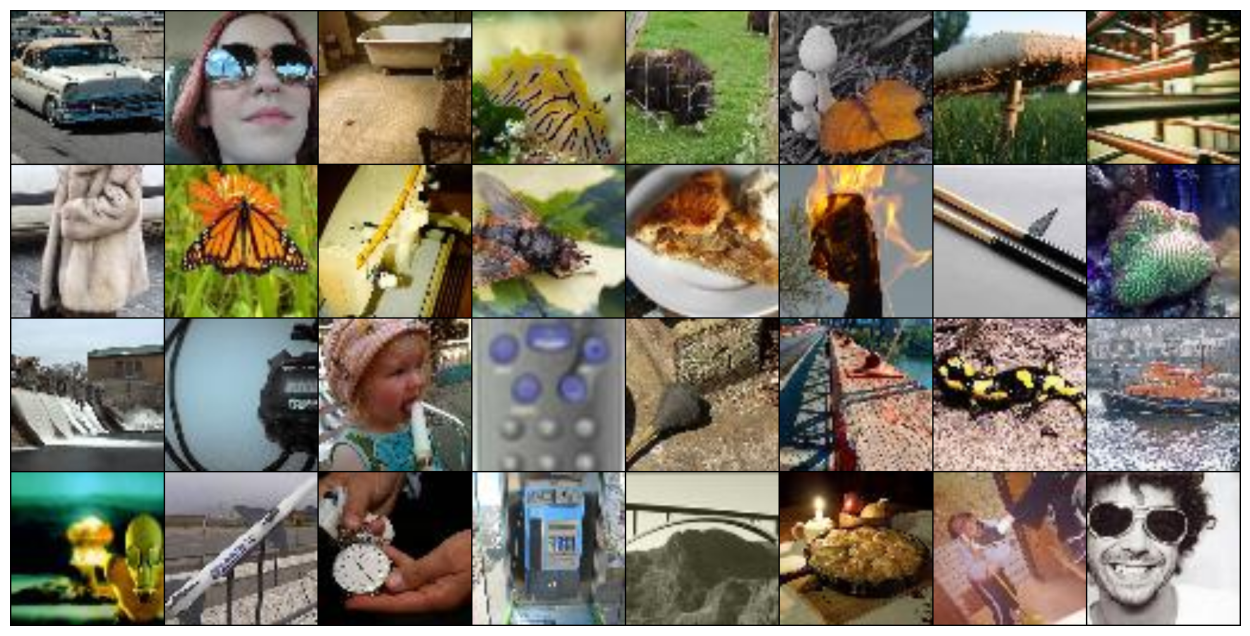

In [14]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt


for images , _ in train_loader:
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images,nrow=8).permute(1,2,0))
    break

## Model

In [15]:
class ConvBlock(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size,padding=0,stride=1):
        super().__init__()
        self.conv=nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            padding=padding,
            stride=stride
        )

        self.bn=nn.BatchNorm2d(out_channels) #Batch Normalization

        self.relu=nn.ReLU()

    def forward(self,x:torch.Tensor):
        return self.relu(self.bn(self.conv(x)))

In [16]:
class InceptionBlock(nn.Module):
    def __init__(self,in_channels,
                out_conv_1_1,
                out_conv_3_3_complement,
                out_conv_3_3,
                out_conv_5_5_complement,
                out_conv_5_5,
                out_conv_pool):
        super().__init__()
        #Camino 1
        self.conv_1_1=ConvBlock(
            in_channels=in_channels,
            out_channels=out_conv_1_1,
            kernel_size=1
        )

        #Camino 2
        self.conv_3_3_complement=ConvBlock(
            in_channels=in_channels,
            out_channels=out_conv_3_3_complement,
            kernel_size=1
        )

        self.conv_3_3=ConvBlock(
            in_channels=out_conv_3_3_complement,
            out_channels=out_conv_3_3,
            kernel_size=3,
            padding=1
        )

        #Camino 3
        self.conv_5_5_complement=ConvBlock(
            in_channels=in_channels,
            out_channels=out_conv_5_5_complement,
            kernel_size=1
        )

        self.conv_5_5=ConvBlock(
            in_channels=out_conv_5_5_complement,
            out_channels=out_conv_5_5,
            kernel_size=5,
            padding=2
        )

        #Camino 4
        self.max_pool=nn.MaxPool2d(
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.pool_proj=ConvBlock(
            in_channels=in_channels,
            out_channels=out_conv_pool,
            kernel_size=1
        )
    
    def forward(self,x:torch.Tensor):
        
        x1=self.conv_1_1(x)

        x2=self.conv_3_3_complement(x)
        x2=self.conv_3_3(x2)

        x3=self.conv_5_5_complement(x)
        x3=self.conv_5_5(x3)

        x4=self.max_pool(x)
        x4=self.pool_proj(x4)

        x=torch.cat([x1,x2,x3,x4],dim=1)  #dim=1 --> los out_channels de cada uno se suman y forman el out_channel del bloque en general
        
        return x

## Auxiliary 

Es un bloque de clasificación que surge de una de las capas intermedias. Tenemos en cuenta sus predicciones para ayudar a la red a propagar gradientes
a través de las capas más recientes.

In [17]:
class Auxiliary(nn.Module):
    def __init__(self,in_channels,num_classes):
        super().__init__()
        self.avg_pool=nn.AvgPool2d(
            kernel_size=5,
            stride=3
        )

        self.conv_1_1=ConvBlock(
            in_channels=in_channels,
            out_channels=128,
            kernel_size=1
        )

        self.fc1=nn.Linear(2048,1024)
        self.fc2=nn.Linear(1024,num_classes)

        self.droput=nn.Dropout(0.7)
        self.relu=nn.ReLU()

    def forward(self,x:torch.Tensor):

        x=self.avg_pool(x)

        x=self.conv_1_1(x)

        x=x.view(x.shape[0],-1) #es como aplicar un flatten

        x=self.fc1(x)
        x=self.relu(x)
        x=self.droput(x)
        x=self.fc2(x)
        return x

In [18]:
class Inception(nn.Module):
    def __init__(self,in_channels=3,
                use_auxiliary=True,
                num_classes=1000):
        super().__init__()
        #self.training=training

        self.conv_1=ConvBlock(
            in_channels=in_channels,
            out_channels=64,
            kernel_size=7,
            padding=3, #como se define este valor
            stride=2   #como se define este valor
        )
        self.conv_2=ConvBlock(
            in_channels=64,
            out_channels=192,
            kernel_size=3,
            stride=1,  #como se define este valor
            padding=1  #como se define este valor
        )

        self.max_pool=nn.MaxPool2d(
            kernel_size=3,
            stride=2,  #como se define este valor
            padding=1  #como se define este valor
        )

        self.avg_pool=nn.AvgPool2d(
            kernel_size=7,  #Para aplicar un global avg pool
            stride=1
        )

        self.droput=nn.Dropout(0.4)

        self.linear=nn.Linear(1024,out_features=num_classes)

        self.use_auxiliary=use_auxiliary

        if self.use_auxiliary:

            self.auxiliary4a=Auxiliary(
                in_channels=512,
                num_classes=num_classes)
            
            self.auxiliary4d=Auxiliary(
                in_channels=528,
                num_classes=num_classes
            )
        
        #PRIMER GRUPO DE INCEPTION BLOCK

        self.inception3a=InceptionBlock(in_channels=192,
                                        out_conv_1_1=64,
                                        out_conv_3_3_complement=96,
                                        out_conv_3_3=128,
                                        out_conv_5_5_complement=16,
                                        out_conv_5_5=32,
                                        out_conv_pool=32)
        
        self.inception3b=InceptionBlock(in_channels=64+128+32+32,
                                        out_conv_1_1=128,
                                        out_conv_3_3_complement=128,
                                        out_conv_3_3=192,
                                        out_conv_5_5_complement=32,
                                        out_conv_5_5=96,
                                        out_conv_pool=64)
        
        #SEGUNDO GRUPO DE INCEPTION BLOCK

        self.inception4a=InceptionBlock(in_channels=128+192+96+64,
                                        out_conv_1_1=192,
                                        out_conv_3_3_complement=96,
                                        out_conv_3_3=208,
                                        out_conv_5_5_complement=16,
                                        out_conv_5_5=48,
                                        out_conv_pool=64)
        
        self.inception4b=InceptionBlock(in_channels=192+208+48+64,
                                        out_conv_1_1=160,
                                        out_conv_3_3_complement=112,
                                        out_conv_3_3=224,
                                        out_conv_5_5_complement=24,
                                        out_conv_5_5=64,
                                        out_conv_pool=64)
        
        self.inception4c=InceptionBlock(in_channels=160+224+64+64,
                                        out_conv_1_1=128,
                                        out_conv_3_3_complement=128,
                                        out_conv_3_3=256,
                                        out_conv_5_5_complement=24,
                                        out_conv_5_5=64,
                                        out_conv_pool=64)
        
        self.inception4d=InceptionBlock(in_channels=128+256+64+64,
                                        out_conv_1_1=112,
                                        out_conv_3_3_complement=144,
                                        out_conv_3_3=288,
                                        out_conv_5_5_complement=32,
                                        out_conv_5_5=64,
                                        out_conv_pool=64)
        
        self.inception4e=InceptionBlock(in_channels=112+288+64+64,
                                        out_conv_1_1=112,
                                        out_conv_3_3_complement=144,
                                        out_conv_3_3=288,
                                        out_conv_5_5_complement=32,
                                        out_conv_5_5=64,
                                        out_conv_pool=64)
        
        #TERCER GRUPO DE INCEPTION BLOCK

        self.inception5a=InceptionBlock(in_channels=112+288+64+64,
                                        out_conv_1_1=256,
                                        out_conv_3_3_complement=160,
                                        out_conv_3_3=320,
                                        out_conv_5_5_complement=32,
                                        out_conv_5_5=128,
                                        out_conv_pool=128)
        
        self.inception5b=InceptionBlock(in_channels=256+320+128+128,
                                        out_conv_1_1=384,
                                        out_conv_3_3_complement=192,
                                        out_conv_3_3=384,
                                        out_conv_5_5_complement=48,
                                        out_conv_5_5=128,
                                        out_conv_pool=128)
        
    def forward(self,x:torch.Tensor):
        y=None
        z=None

        x=self.conv_1(x)
        x=self.max_pool(x)
        x=self.conv_2(x)
        x=self.max_pool(x)

        x=self.inception3a(x)
        x=self.inception3b(x)
        x=self.max_pool(x)

        x=self.inception4a(x)

        if self.training and self.use_auxiliary:
            z=self.auxiliary4a(x)

        x=self.inception4b(x)
        x=self.inception4c(x)
        x=self.inception4d(x)
        if self.training and self.use_auxiliary:
            y=self.auxiliary4d(x)

        x=self.inception4e(x)
        x=self.max_pool(x)

        x=self.inception5a(x)
        x=self.inception5b(x)
        x=self.avg_pool(x)

        x=x.view(x.shape[0],-1)
        x=self.droput(x)
        x=self.linear(x)

        return x,y,z

In [19]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [20]:
#creacion de una instancia Inception
torch.manual_seed(42)
model_0=Inception().to(device)
model_0


Inception(
  (conv_1): ConvBlock(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv_2): ConvBlock(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (avg_pool): AvgPool2d(kernel_size=7, stride=1, padding=0)
  (droput): Dropout(p=0.4, inplace=False)
  (linear): Linear(in_features=1024, out_features=1000, bias=True)
  (auxiliary4a): Auxiliary(
    (avg_pool): AvgPool2d(kernel_size=5, stride=3, padding=0)
    (conv_1_1): ConvBlock(
      (conv): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )

In [21]:
image_batch,label_batch=next(iter(train_loader))

image_batch.shape,label_batch.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [22]:
#try a forward pass
model_0(image_batch.to(device))

(tensor([[ 0.1061,  0.4144,  0.0807,  ..., -0.3885, -0.2506, -0.4730],
         [-0.1183, -0.0166,  0.0610,  ..., -0.4771,  0.0339,  0.3703],
         [ 0.1115,  0.1633, -0.3036,  ...,  0.0162, -0.1416, -0.3386],
         ...,
         [ 0.2434,  0.1537, -0.1113,  ...,  0.0733, -0.0303, -0.5983],
         [ 0.3203,  0.1479, -0.2720,  ..., -0.1264, -0.5373, -0.4406],
         [ 0.0763,  0.8454, -0.0919,  ..., -0.3941,  0.1920, -0.5026]],
        device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[ 0.1603, -0.3975,  0.2568,  ..., -0.2647, -0.0355,  0.6653],
         [ 0.1290, -0.1420,  0.0567,  ...,  0.1628,  0.0212,  0.2705],
         [-0.0794, -0.3284, -0.2779,  ..., -0.1417, -0.1729, -0.0193],
         ...,
         [-0.0068, -0.1564,  0.2603,  ...,  0.0993,  0.3803,  0.2608],
         [-0.1408,  0.1271,  0.1965,  ...,  0.0422,  0.2957, -0.0032],
         [-0.2143, -0.1948,  0.0636,  ..., -0.4989,  0.5541,  0.4825]],
        device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[ 0.3

In [23]:
#Create train_step()

def train_step(
        model:nn.Module,
        dataloader:torch.utils.data.dataloader,
        loss_fn:nn.Module,
        optimizer:torch.optim.Optimizer,
        use_auxiliary:bool,
        device):
    
    model.train()

    train_loss,train_acc=0,0

    for batch, (X,y) in enumerate(dataloader):
        X,y=X.to(device),y.to(device)

        if use_auxiliary:
            #1. Forward pass
            y_preds,aux1,aux2=model(X)

            #2. Calculate the loss
            loss=loss_fn(y_preds,y) + 0.3*loss_fn(aux1,y) + 0.3*loss_fn(aux2,y)
        else:
            y_preds,_,_=model(X)
            loss=loss_fn(y_preds,y)
        
        train_loss+=loss

        #3. Optimizer zero grad
        optimizer.zero_grad()

        #4. Loss backward
        loss.backward()

        #5. Optimizer step
        optimizer.step()

        #Calculate accuracy metric
        y_pred_class=torch.argmax(
            torch.softmax(y_preds,dim=1),
            dim=1
        )

        train_acc+= (y_pred_class == y).sum().item() / len(y_preds)

    #Adjust metrics to get average loss and accuracy per batch
    train_loss=train_loss / len(dataloader)
    train_acc=train_acc / len(dataloader)

    return train_loss,train_acc

In [24]:
import torch.utils
import torch.utils.data


def test_step(model:nn.Module,
        dataloader:torch.utils.data.DataLoader,
        loss_fn:nn.Module,
        device=device):
    
    model.eval()

    test_loss,test_acc=0,0

    with torch.inference_mode():

        for batch, (X,y) in enumerate(dataloader):
            X,y=X.to(device),y.to(device)

            test_preds_logits,_,_=model(X)

            loss=loss_fn(test_preds_logits,y)
            test_loss+=loss.item()

            test_preds_labels=torch.argmax(
                torch.softmax(test_preds_logits,dim=1),
                dim=1
            )

            test_acc+=(test_preds_labels == y).sum().item() / len(test_preds_labels)
        
    test_loss = test_loss / len(dataloader)
    test_acc  = test_acc / len(dataloader)
    
    return test_loss, test_acc

In [25]:
from tqdm.auto import tqdm

def train_model(model:nn.Module,
                train_dataloader:torch.utils.data.DataLoader,
                test_datalaoder:torch.utils.data.DataLoader,
                optimizer:torch.optim.Optimizer,
                lr_scheduler:torch.optim.lr_scheduler,
                use_auxiliary:bool,
                loss_fn:nn.Module=nn.CrossEntropyLoss(),
                epochs=1,
                device=device):
    
    results={
        "train_loss":[],
        "train_acc":[],
        "test_loss":[],
        "test_acc":[]
    }

    for epoch in tqdm(range(epochs)):
        #train_step
        train_loss,train_acc=train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            use_auxiliary=use_auxiliary,
            device=device
        )
        #test_step
        test_loss,test_acc=test_step(
            model=model,
            dataloader=test_datalaoder,
            loss_fn=loss_fn,
            device=device
        )
        #lr_scheduler step
        lr_scheduler.step(test_loss) #modify later
        lr_scheduler.get_last_lr() #modify later

        print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.2f}% | Test loss: {test_loss:.4f} | Test acc: {test_acc:.2f}%")

        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)

    return results

c:\Tesis\Tesis\Codigo\model_pytorch\venv2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
loss_fn=nn.CrossEntropyLoss()
optimizer=optim.Adam(
    params=model_0.parameters(),
    lr=0.1,
    weight_decay=1e-4
)
lr_scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,patience=5)
NUM_EPOCHS=3

In [27]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_0_results=train_model(
    model=model_0,
    train_dataloader=train_loader,
    test_datalaoder=test_loader,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    use_auxiliary=True,
    loss_fn=loss_fn,
    epochs=NUM_EPOCHS,
    device=device
)

 33%|███▎      | 1/3 [03:58<07:56, 238.20s/it]

Epoch: 0 | Train loss: 9.4410 | Train acc: 0.01% | Test loss: 12.0266 | Test acc: 0.00%


 67%|██████▋   | 2/3 [07:59<04:00, 240.29s/it]

Epoch: 1 | Train loss: 8.7686 | Train acc: 0.00% | Test loss: 5.5074 | Test acc: 0.00%


100%|██████████| 3/3 [12:03<00:00, 241.17s/it]

Epoch: 2 | Train loss: 8.7734 | Train acc: 0.01% | Test loss: 5009.3933 | Test acc: 0.00%


In [58]:
dataset.class_to_idx

{'n01443537': 0,
 'n01629819': 1,
 'n01641577': 2,
 'n01644900': 3,
 'n01698640': 4,
 'n01742172': 5,
 'n01768244': 6,
 'n01770393': 7,
 'n01774384': 8,
 'n01774750': 9,
 'n01784675': 10,
 'n01855672': 11,
 'n01882714': 12,
 'n01910747': 13,
 'n01917289': 14,
 'n01944390': 15,
 'n01945685': 16,
 'n01950731': 17,
 'n01983481': 18,
 'n01984695': 19,
 'n02002724': 20,
 'n02056570': 21,
 'n02058221': 22,
 'n02074367': 23,
 'n02085620': 24,
 'n02094433': 25,
 'n02099601': 26,
 'n02099712': 27,
 'n02106662': 28,
 'n02113799': 29,
 'n02123045': 30,
 'n02123394': 31,
 'n02124075': 32,
 'n02125311': 33,
 'n02129165': 34,
 'n02132136': 35,
 'n02165456': 36,
 'n02190166': 37,
 'n02206856': 38,
 'n02226429': 39,
 'n02231487': 40,
 'n02233338': 41,
 'n02236044': 42,
 'n02268443': 43,
 'n02279972': 44,
 'n02281406': 45,
 'n02321529': 46,
 'n02364673': 47,
 'n02395406': 48,
 'n02403003': 49,
 'n02410509': 50,
 'n02415577': 51,
 'n02423022': 52,
 'n02437312': 53,
 'n02480495': 54,
 'n02481823': 55,
 '